In [174]:
# IMPORTS

#---------------------------------------------
# Standard libraries
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from astropy import constants as astro_const

#---------------------------------------------
# Specific libraries
import copy # To copy multidimensional arrays
from scipy import signal # Signal analysis
# To measure execution times
import time
from tqdm import tqdm

#---------------------------------------------
# Files managing
import os

#---------------------------------------------
# Animations
import imageio

In [175]:
# INPUT READING FUNCTIONS (NBODY_SH1)

#---------------------------------------------
# Read the input file:
#
# N = number of particles
# t_0 = initial time
# particles_0 = collection of mass + 6D position/velocity vector for every particle in the system
# The shape of particles is: [[m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1], 
#                             [m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2],
#                             ...,
#                             [m_N x_N, y_N, z_N, vx_N, vy_N, vz_N]]
#
# Returns:
#         a snapshot ("snapshot_0") of the system at the initial condition in the shape:
#         [N, t_0, particles_0] :   [N, t_0, [[m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1], 
#                                             [m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2],
#                                             ...,
#                                             [m_N x_N, y_N, z_N, vx_N, vy_N, vz_N]]]
#
# Input file is structured as follow:
#
# N
# t_0
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
def read_input_nbodysh1(input_file_path):
    input_file = open(input_file_path)

    # readline() reads the first line and returns it as a string
    N = int(input_file.readline())
    t_0 = float(input_file.readline())

    # readlines() reads all the remaining lines and returns them into a list of strings
    particles_0 = input_file.readlines()

    input_file.close()

    # Convert the list of strings into a list of lists of number
    for i in range(len(particles_0)):
        # split() splits a string based on a separator (default is ' ') and returns a list of strings
        particles_0[i] = particles_0[i].split()

        # Convert the elements of each splitted string into numbers
        for j in range(len(particles_0[i])):
            particles_0[i][j] = float(particles_0[i][j])

    snapshot_0 = [N, t_0, particles_0]

    return snapshot_0

#-----------------------------------------------------------------------------
# Read the output file:
# Output file is structured as follow:
#
# N
# t_1
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
# N
# t_2
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
#
# ...
#
# N
# t_f
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
#
# Returns a list of snapshot of the evolved system (t>t_0)
# See read_input for details on the snapshots
def read_output_nbodysh1(output_file_path):
    output_file = open(output_file_path)

    # List to store all the snapshots in the output file
    snapshots = []

    # Try except here detects the EOF
    # int() throws an exception when tries to convert something different than a number
    while True:
        try:
            N = int(output_file.readline())
        except:
            break

        # Line after N is the time stamp of the snapshot
        t_stamp = float(output_file.readline())

        # Collect strings of mass + 6D position/velocity vector N times (for N particles)
        particles = [output_file.readline() for i in range (N)]

        # Convert the list of strings into a list of lists of number (same as for read_input())
        for i in range(len(particles)):
            particles[i] = particles[i].split()

            for j in range(len(particles[i])):
                particles[i][j] = float(particles[i][j])
        
        # Append the snapshot [N, t_stamp, particles] to the snapshots list
        snapshots.append([N, t_stamp, particles])

    output_file.close()
    
    return snapshots

#--------------------------------------------------------------------------
# Returns the complete list of snapshots of the system (including the initial one)
#
# How to navigate the snapshots:
# 1) Choose the snapshot:
#    *** snapshots[snapshot_index, from 0 to len(snapshot)-1] ***
#
# 2) What do you want?
#    A) Number of particles:
#       *** snapshot[snapshot_index][0] ***
#       Note that snapshot[snapshot_index][0] can't be subscripted anymore
#
#    B) Time stamp: 
#       *** snapshot[snapshot_index][1] ***
#       Note that snapshot[snapshot_index][1] can't be subscripted anymore
#
#    C) Particles masses, positions and velocities:
#       *** snapshot[snapshot_index][2] ***
#       This is a list of lists (see read_input() for details)
#
# 3) Which particle are you interested in?
#    *** snapshot[snapshot_index][2][particle_index, from 0 to N-1] ***
#
# 4) What do you want to know about the particle:
#    *** Mass: snapshot[snapshot_index][2][particle_index][0] ***
#    *** x, y, z: snapshot[snapshot_index][2][particle_index][1, 2, 3] ***
#    *** vx, vy, vz: snapshot[snapshot_index][2][particle_index][1+3, 2+3, 3+3] ***
def read_snapshots_nbodysh1(input_file_path, output_file_path):
    snapshot_0 = read_input_nbodysh1(input_file_path)
    snapshots = read_output_nbodysh1(output_file_path)

    # Append the intial snapshot to the beginning of the list
    snapshots = [snapshot_0] + snapshots

    return snapshots

In [176]:
# INPUT READING FUNCTIONS (TREECODE)

#---------------------------------------------
# Input and output files for the treecode program are different than those for nbody_sh1
# Nevertheless the output of the reading functions have the same shape of those for the nbody_sh1
# There are just small variations depending on the parameters: include_ndim and contains_pot
# Read the explanations for the details. Refer to nbody_sh1 i/o functions for reference about
# how 'snapshots' works

#---------------------------------------------
# read_input_treecode() is just for completeness since the treecode program appends
# the initial snapshot at the beginning of the output file, as opposed to the nbody_sh1 program
# Read it for reference for read_output_treecode()
# Input file is structured as follow:
#
# N
# n_dim
# t_0
# m_1
# ..
# m_N
# x_1, y_1, z_1
# ...
# x_N, y_N, z_N
# vx_1, vy_1, vz_1
# ...
# vx_N, vy_N, vz_N
def read_input_treecode(input_file_path, include_ndim=False):
    input_file = open(input_file_path)

    # readline() reads the first line and returns it as a string
    N = int(input_file.readline())
    n_dim = int(input_file.readline())
    t_0 = float(input_file.readline())

    masses = []
    positions = []
    velocities = []

    # Works like this: data[quantity][particle]
    data = [masses, positions, velocities]

    for i in range(3):
        for j in range(N):
                data[i].append(input_file.readline())
                # split() splits a string based on a separator (default is ' ') and returns a list of strings
                data[i][j] = data[i][j].split()
                # Convert the elements of each splitted string into numbers
                for k in range(len(data[i][j])):
                    data[i][j][k] = float(data[i][j][k])

    # At this point 'data' works like this: data[quantity][particle_index][quantity_index]
    #                                       quantity: 0, 1, 2 (mass, positions, velocities)
    #                                       particle: 0, 1, 2, ..., N-1
    #                                       quantity_index: just 0 if quantity = 0
    #                                                       0, 1, 2 (x, y, z) if quantity = 1
    #                                                       0, 1, 2 (vx, vy, vz) if quantity = 2
    input_file.close()

    # Populate 'particles_0' by cycling over 'data'
    particles_0 = []

    for j in range(N):
        particle_0 = []
        for i in range(3):
            for k in range(len(data[i][j])):
                particle_0.append(data[i][j][k])
        particles_0.append(particle_0)

    # Wether to include n_dim in the snapshot or not
    if include_ndim:
        snapshot_0 = [N, t_0, particles_0, n_dim]
    else:
        snapshot_0 = [N, t_0, particles_0]

    return snapshot_0

#-----------------------------------------------------------------------------
# Read the output file:
# Output file is structured like the input file, but for the fact the structure
# is repeated for every time.
# See read_input() for details
# Returns a list of snapshot of the evolved system (t>t_0)
# If contains_pot=True then to each particle also its potential energy is attached at index 7
def read_output_treecode(output_file_path, include_ndim=False, contains_pot=True):
    output_file = open(output_file_path)

    # List to store all the snapshots in the output file
    snapshots = []

    # Try except here detects the EOF
    # int() throws an exception when tries to convert something different than a number
    while True:
        try:
            N = int(output_file.readline())
        except:
            break

        # LIKE read_input() START
        
        n_dim = int(output_file.readline())
        t_stamp = float(output_file.readline())

        masses = []
        positions = []
        velocities = []
        potentials = []

        if contains_pot:
            data = [masses, positions, velocities, potentials]
        else:
            data = [masses, positions, velocities]

        for i in range(len(data)):
            for j in range(N):
                    data[i].append(output_file.readline())
                    data[i][j] = data[i][j].split()
                    for k in range(len(data[i][j])):
                        data[i][j][k] = float(data[i][j][k])
        
        particles = []

        for j in range(N):
            particle = []
            for i in range(len(data)):
                for k in range(len(data[i][j])):
                    particle.append(data[i][j][k])
            particles.append(particle)

        # LIKE read_input() END
        
        # Append the snapshot [N, t_stamp, particles] to the snapshots list
        if include_ndim:
            snapshots.append([N, t_stamp, particles, n_dim])
        else:
            snapshots.append([N, t_stamp, particles])

    output_file.close()
    
    return snapshots

#--------------------------------------------------------------------------
# SEE read_output() for when potential energy is given in the file
def read_snapshots_treecode(input_file_path, output_file_path, include_ndim=False):
    snapshot_0 = read_input_treecode(input_file_path, include_ndim)
    snapshots = read_output_treecode(output_file_path, include_ndim)

    # Append the intial snapshot to the beginning of the list
    snapshots = [snapshot_0] + snapshots

    return snapshots

In [177]:
# MATHEMATICAL FUNCTIONS

#-------------------------------------------------------------------------
# Returns the difference between two vectors (vector_2 - vector_1)
# 
# If vectors are positions:
# It is a vector that points from position_1 to position_2: [x_2 - x_1, y_2 - y_1, z_2 - z_1]
# 
# If vectors are velocities:
# It is a vectors that describes the relative velocity in the frame in which particle 1 is at rest
# [vx_2 - vx_1, vy_2 - vy_1, vz_2 - vz_1]
#
# Imput parameters should be strictly numpy arrays of 3 numbers: (x, y, z)
def compute_vector_diff(vector_1, vector_2):
    return vector_2 - vector_1

# Returns the vectorial product of two vectors
# Imput parameters are strictly numpy arrays of 3 numbers: (x, y, z)
# Consider using np.cross()
def compute_vectorial_product(vector_1, vector_2):
    x = vector_1[1] * vector_2[2] - vector_1[2] * vector_2[1]
    y = vector_1[2] * vector_2[0] - vector_1[0] * vector_2[2]
    z = vector_1[0] * vector_2[1] - vector_1[1] * vector_2[0]

    return np.array([x, y, z])

# Returns the absolute value of a vector to the absval-th power
def compute_vector_abs(vector, absval=1):
    value = 0

    for i in range(len(vector)):
        value += vector[i] ** 2
    
    # Don't waste computational power if you want the square of the vector
    if absval == 2:
        pass
    else:
        value = value ** (absval / 2)

    return value

# Returns the distance between two points
# Imput parameters are arrays of 3 numbers: (x, y, z)
def compute_distance(point_1, point_2):
    distance = 0
    for i in range (3):
        distance += (point_1[i] - point_2[i]) ** 2
    
    return distance ** (1 / 2)

In [178]:
# COORDINATES FUNCTIONS

#----------------------------------------------------------------
# Returns the 3D vector (x, y, z) correspoding to the spherical_coordinates (r, theta, phi)
# Imput parameter is strictly a numpy array of 3 numbers: (r, theta, phi)
def spherical_to_cartesian(spherical_coordinates):
    r = spherical_coordinates[0]
    theta = spherical_coordinates[1]
    phi = spherical_coordinates[2]

    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    # Floating point precision would not give exact results around zeros of goniometric functions
    return np.array([x, y, z])

# Returns the 3D vector (r, theta, phi) correspoding to the cartesian_coordinates (x, y, z)
# Imput parameter is strictly a numpy array of 3 numbers: (x, y, z)
def cartesian_to_spherical(cartesian_coordinates):
    x = cartesian_coordinates[0]
    y = cartesian_coordinates[1]
    z = cartesian_coordinates[2]

    r = ((x ** 2) + (y ** 2) + (z ** 2)) ** (1 / 2)

    if x == 0 and y == 0 and z == 0:
        theta = None
    else:
        theta = np.arccos(z / r)

    if x == 0 and y == 0:
        phi = None
    else:
        phi = np.arccos(x / (r * np.sin(theta)))
        if y < 0:
            phi = 2 * np.pi - phi
    
    # Floating point precision would not give exact results around zeros of goniometric functions
    return np.array([r, theta, phi])

In [179]:
# SNAPSHOTS READING FUNCTIONS & SMALL CALCULATIONS

#------------------------------------------------------------------
# Reads an 'indexes' parameter and converts it into a numpy array
# 'indexes' can be an integer, a numpy array (of specified indexes) or 'all'
# If indexes='all', also 'all_number' must be specified; it is the lenght of
# the list of all indexes. It must be > 0
# Returns a numpy array containing the required indexes
def indexes_par_reader(indexes, all_number=None):
    # If indexes = 'all', get all indexes
    if (type(indexes) == str and indexes == 'all' and
        (type(all_number) == int or type(all_number) == np.int_) and all_number > 0):
        _indx = np.array(range(all_number))

    # If 'indexes' is an integer, make an array of one element containing it
    elif type(indexes) == int or type(indexes) == np.int_:
        _indx = np.array([indexes])
    
    # If 'indexes' is already a 1 dimension numpy array, return it as it is
    elif (type(indexes) == np.ndarray) and (indexes.ndim == 1):
        _indx = np.copy(indexes)

    return _indx
    
# Returns an array of the number of particles of the snapshots
def get_N(snapshots):
    return np.array([snapshots[i][0] for i in range(len(snapshots))])

# Returns an array of the time stamps of the snapshots
def get_timestamps(snapshots):
    return np.array([snapshots[i][1] for i in range(len(snapshots))])

# Returns an array of the specified masses at the specified times
# If total=True returns the total mass
# particle_indexs are the indexes of the masses to consider
# time_indexes are the indexes of the snapshot times to consider
# They can be numpy arrays, single integer values or 'all'
#
# *** WARNINGS ***
#
# See *** WARNINGS *** in get_3d_vec()
def get_masses(snapshots, particle_indexes, total=False, time_indexes=0):
    # See get_3d_vec() for explanation
    T_indx = indexes_par_reader(time_indexes, len(snapshots))

    if type(time_indexes) == int or type(time_indexes) == np.int_:
        P_indx = indexes_par_reader(particle_indexes, len(snapshots[time_indexes][2]))
    else:
        P_indx = indexes_par_reader(particle_indexes, snapshots[0][0])

    masses = np.zeros((len(T_indx), len(P_indx)))

    for r_t_i, time_index in zip(range(len(T_indx)), T_indx):
        for r_p_i, particle_index in zip(range(len(P_indx)), P_indx):
            masses[r_t_i][r_p_i] = snapshots[time_index][2][particle_index][0]
        if total:
            masses[r_t_i] = np.sum(masses[r_t_i])

    if total:
        masses = np.delete(masses, slice(1, len(P_indx)), axis=1)

    if masses.shape == (1, 1):
        return masses[0][0]
    else:
        return np.squeeze(masses)

# Compute the position or velocity of the center of mass for the specified times
# Returns an array with shape: [[qt_x, qt_y, qt_z]_ti_0, ..., [qt_x, qt_y, qt_z]_ti_(len(time_indexes)-1)]
# vec = 'pos', 'vel'
# time_indexes are the indexes of the snapshot that will be taken into account
# particle_indexs are the indexes of the masses to consider
# They can be numpy arrays, single integer values or 'all'
#
# *** WARNINGS ***
#
# See *** WARNINGS *** in get_3d_vec()
def get_center_of_mass(snapshots, time_indexes, vec='', particle_indexes='all'):
    # See get_3d_vec() for explanation
    T_indx = indexes_par_reader(time_indexes, len(snapshots))

    if type(time_indexes) == int or type(time_indexes) == np.int_:
        P_indx = indexes_par_reader(particle_indexes, len(snapshots[time_indexes][2]))
    else:
        P_indx = indexes_par_reader(particle_indexes, snapshots[0][0])
    
    M_tot = get_masses(snapshots, particle_indexes=P_indx, total=True, time_indexes=T_indx)
    if type(M_tot) == np.float_:
        M_tot = np.array([M_tot])
    
    if vec.lower() == 'pos':
        shift = 0
    elif vec.lower() == 'vel':
        shift = 3

    qt_CM = np.zeros((len(T_indx), 3))

    for r_t_i, time_index in zip(range(len(T_indx)), T_indx):
        for coordinate_index in range(3):
            for particle_index in P_indx:
                qt_CM[r_t_i][coordinate_index] += (snapshots[time_index][2][particle_index][0] *
                                                   snapshots[time_index][2][particle_index][1+
                                                                                            coordinate_index+
                                                                                            shift])
            qt_CM[r_t_i][coordinate_index] /= M_tot[r_t_i]

    return np.squeeze(qt_CM)

# absval = 0: returns an array of 3D vectors of the specified particles, for the specified quantity
#             in the specified reference frame
# [[Qx_0, Qy_0, Qz_0], [Qx_1, Qy_1, Qz_1], ..., [len(snapshots)-1]]
# absval = n != 0: returns the absolute value of the vectors to the absval-th power
# vec = 'pos', 'vel'
# rf = 'snapshot', 'cm' (center of mass), 'particle' (specify which particle with the next parameter)
# particle_indexes and time_indexes are the indexes of the snapshot that will be taken into account
# They can be numpy arrays, single integer values or 'all'
#
# *** WARNINGS ***
#
# It is reccomended to use the 'indexes' parameters to get the desired values because it is
# more efficient in this implementation than doing more function calls
# 
# In order to use the indexes parameters as arrays, is required for the snapshot parameter
# to be homogneous in shape between axis 0 and axis 2, i.e.  the number of particles
# in the snapshot should be the same at every time
# If this condition is not satisfied, runtime errors might occour
def get_3D_vec(snapshots, particle_indexes, vec='', absval=0, rf='snapshot',
               rf_particle_index=None, time_indexes='all'):
    if vec.lower() == 'pos':
        shift = 0
    elif vec.lower() == 'vel':
        shift = 3
    
    # Convert the 'indexes' parameters into numpy arrays
    # See indexes_par_reader() for details
    T_indx = indexes_par_reader(time_indexes, len(snapshots))

    # The following 'if' statement is to allow the function to work even if
    # an inhomogeneous snapshot is passed as a parameter (see above for details)
    # If that is the case, this should garantee the result at least when integers paramters
    # are passed to the 'indexes' parameters
    if type(time_indexes) == int or type(time_indexes) == np.int_:
        P_indx = indexes_par_reader(particle_indexes, len(snapshots[time_indexes][2]))
    else:
        P_indx = indexes_par_reader(particle_indexes, snapshots[0][0])

    # Initialise the result
    result = np.zeros((len(P_indx), len(T_indx), 3))

    # If required, compute the center of mass at the specified times using all the masses
    if rf.lower() == 'cm':
        cm_vec = get_center_of_mass(snapshots, T_indx, vec, particle_indexes='all')

    for r_p_i, particle_index in zip(range(len(P_indx)), P_indx):
        # Compute in the snapshot reference frame
        if rf.lower() == 'snapshot':
            for r_t_i, time_index in zip(range(len(T_indx)), T_indx):
                result[r_p_i][r_t_i] = snapshots[time_index][2][particle_index][1+shift:4+shift]

        # Compute in the center of mass reference frame
        elif rf.lower() == 'cm':
            particle_vec = np.array([snapshots[time_index][2][particle_index][1+shift:4+shift]
                                     for time_index in T_indx])
            result[r_p_i] = compute_vector_diff(cm_vec, particle_vec)

        # Compute in the reference frame of the specified particle
        elif rf.lower() == 'particle':
            rf_particle_vec = np.array([snapshots[time_index][2][rf_particle_index][1+shift:4+shift]
                                        for time_index in T_indx])
            particle_vec = np.array([snapshots[time_index][2][particle_index][1+shift:4+shift]
                                     for time_index in T_indx])
            result[r_p_i] = compute_vector_diff(rf_particle_vec, particle_vec)
    
    # Return the result as it is
    if absval == 0:
        pass
    
    # Compute the absval-th power of every vector into "result"
    elif absval != 0:
        for particle_index in range(len(result)):
            for time_index in range(len(result[particle_index])):
                result[particle_index][time_index] = compute_vector_abs(result[particle_index][time_index],
                                                                        absval)

        # Because of how numpy arrays works, we need to slice the array to take the first column
        # Actually any column would be fine because now their content is equal
        # The point is that we want just one set of values and not three
        result = np.delete(result, [1, 2], axis=2)

    # Squeeze the array to get rid of the 1-element lists
    # Or take the [0][0][0] element if all axis have lenght 1 to avoid a 0 dimensions array
    if result.shape == (1, 1, 1):
        return result[0][0][0]
    else:
        return np.squeeze(result)

# Returns the potentials of each particle at the specified time
# Works only if the overal potential for each particle at every time
# is part of 'snapshots'
def get_saved_potentials(snapshots, time_index):
    return np.array([snapshots[time_index][2][particle_index][7]
                     for particle_index in range(snapshots[time_index][0])])

In [180]:
# PHYSICS FUNCTIONS

#-------------------------------------------------------------------------
# Returns the energy of the system for the specified time in the specified reference frame
# E_type = 'kin', 'pot', 'tot', 'all'. If 'all', returns an ordered tuple: (E_kin, E_pot, E_tot)
# rf = 'snapshot', 'cm' (center of mass)
# E_parts_kin and E_parts_pot are numpy arrays passed to the fucntion that can be modified
# This is exactly because they are arrays and the function will read their memory addresses
# They will be modified only if they have the right shape: E_parts_kin: (N, )
#                                                          E_parts_pot: (N, N); (N, ) if contains_pot=True
# Where N is the number of particles
# If contains_pot=True then the potential energy of each particle is read from the snapshot
# (index 7 of each particle, after vz)
#
# *** ABOUT E_parts ***
#
# E_parts_kin is a collection of the kinetic energies of every particle at the specified time
# It works like this: E_parts_kin[particle_index]
#
# E_parts_pot is a collection of the potential energies of every particle
# with all other particles at the specified time
# It works like this: E_parts_pot[particle_index][particle_index]
# Self energies are set to zero: E_parts_pot[i][j] = 0 if i = j
# Note that if you want the total potential energy at a given time you can sum all the contents of 
# E_parts_pot but you have to divide by 2 at the end because it is a symmetric matrix
#
# if contains_pot=True, E_parts_pot will work like this: E_parts_pot[particle_index] where this time
# each element contains the overall potential felt by the specified particle
# Summing everything and dividing by 2 gives the potential energy
#
# I think that further generalisation of this function might be troublesome
# and would not lead to tangible advantages
def get_energy(snapshots, time_index, E_type='', rf='snapshot', rf_particle_index=None,
               E_parts_kin=None, E_parts_pot=None, contains_pot=False):
    N = snapshots[time_index][0]

    if E_type.lower() == 'kin':
        E = 0
        
        # An array of the velocities squared of every mass at the specified time
        # [v_0_time_index, v_1_time_index, v_2_time_index, ..., v_(N-1)_time_index]
        v_squared = get_3D_vec(snapshots, 'all', 'vel', 2, rf, rf_particle_index, time_indexes=time_index)

        for i in range(N):
            value = (1 / 2) * snapshots[time_index][2][i][0] * v_squared[i]
            E += value

            # If requested save the individual kinetic energy
            if type(E_parts_kin) == np.ndarray and E_parts_kin.shape == (N, ):
                E_parts_kin[i] = value
    elif E_type.lower() == 'pot':
        E = 0

        # If snapshots doesn't contain potentials, compute them
        # Depending on the number of particles, this might take a (long) while
        if not contains_pot:
            # Same as above but it's for position vectors
            # positions[i] is the 3D vector of the i-th particle at specified time
            #
            # Note that since we need just the relative distances between particles, it is not
            # necessary to compute the positions in a reference frame different from 'snapshot'
            # Infact relative distances are frame independent
            # This solution is preferable because more computationally efficient
            positions = get_3D_vec(snapshots, 'all', 'pos', rf='snapshot', time_indexes=time_index)

            # Cycle over all possible combination of particles
            # part_0: part_1, part_2, part_3, ..., part_(N-1)
            # part_1: part_2, part_3, part_4, ..., part_(N-1)
            # part_2: part_3, part_4, part_5, ..., part_(N-1)
            # ...
            # part_i: part_(i+1), part_(i+2), ..., part_(N-1)
            for i in range(N):
                for j in range(i+1, N):
                    distance = compute_distance(positions[i], positions[j])
                    value = -1 * snapshots[time_index][2][i][0] * snapshots[time_index][2][j][0] / distance
                    E += value

                    # If requested save the individual potential energy interaction
                    # Build up a symmetric matrix
                    if type(E_parts_pot) == np.ndarray and E_parts_pot.shape == (N, N):
                        E_parts_pot[i][j] = value
                        E_parts_pot[j][i] = value

        # If snapshots contains potentials, use them instead
        # See the explanation in the description above
        else:
            saved_potentials = get_saved_potentials(snapshots, time_index)
            E += np.sum(saved_potentials) / 2
            if type(E_parts_pot) == np.ndarray and E_parts_pot.shape == (N, ):
                # copyto() just provides an elegant way to copy array elements into another
                # without going through a cycle. We want this because E_parts_pot points to an external array
                np.copyto(E_parts_pot, saved_potentials)
    elif E_type.lower() == 'tot':
        E_kin = get_energy(snapshots, time_index, 'kin', rf, rf_particle_index,
                           E_parts_kin, E_parts_pot, contains_pot)
        E_pot = get_energy(snapshots, time_index, 'pot', rf, rf_particle_index,
                           E_parts_kin, E_parts_pot, contains_pot)
        E = E_kin + E_pot

    elif E_type.lower() == 'all':
        E_kin = get_energy(snapshots, time_index, 'kin', rf, rf_particle_index,
                           E_parts_kin, E_parts_pot, contains_pot)
        E_pot = get_energy(snapshots, time_index, 'pot', rf, rf_particle_index,
                           E_parts_kin, E_parts_pot, contains_pot)
        E = E_kin + E_pot

        E = E_kin, E_pot, E

    return E

In [181]:
# PROBLEM SPECIFIC FUNCTIONS

#-------------------------------------------------
def expected_lagrangian_radius(b, q):
    return b / np.sqrt(q ** (-2 / 3) - 1)

In [182]:
# GLOBAL VARIABLES

#---------------------------------------------
# Relevant constants in CGS
G = astro_const.G.cgs
M_sun = astro_const.M_sun.cgs
kpc = astro_const.kpc.cgs

# Internal units conversion factors: G = 1, M = 1 M_sun, r = 1 kpc
v_I_to_v_cgs = (G * M_sun / kpc) ** (1 / 2)
t_I_to_t_cgs = kpc / v_I_to_v_cgs

# Strings for units
mass_unit_str = r"$M_\odot$"
distance_unit_str = r"$kpc$"

# Printing conversion factors
print(v_I_to_v_cgs)
print(t_I_to_t_cgs)

207.38652969844205 cm / s
1.4878871766542453e+19 s


In [183]:
# FILE READING

#----------------------------------------------------------------
input_file_path = "input_1.txt"
output_file_path = "output_1_1.txt"

# The output already includes the initial snapshot
snapshots = read_output_treecode(output_file_path)

In [184]:
N = snapshots[0][0] # Number of particles

# "pos" works like this: pos[particle_index][time_index][coordinate_index]
pos = get_3D_vec(snapshots, 'all', 'pos', rf='snapshot')

# "cm_pos" works like this: cm_pos[time_index][coordinate_index]
cm_pos = get_center_of_mass(snapshots, time_indexes='all', vec='pos')

time_stamp = get_timestamps(snapshots)

In [185]:
# ENERGY

#----------------------------------------------------
# Initialize a dictionary for the energy
# Each key, 'kin', 'pot', 'tot', will contain an array of values describing the corresponding
# energy for every time stamp. Example: Energy['kin'] = [E_kin_0, E_kin_1, ..., E_kin_(len(snapshot)-1)]
Energy = {}
Energy_keys = ['kin', 'pot', 'tot']

# Initialise correctly shaped arrays to store the individual values
# of the kinetic and potential energy during the calculation
# Their time axes (axes 0) entries will be modified by get_energy() when passed as parameters
# See get_energy() for details

# It works likw this: particles_E_kin[time_index][particle_index]
particles_E_kin = np.zeros((len(snapshots), N))
# It works likw this: particles_E_pot[time_index][particle_index]
particles_E_pot = np.zeros((len(snapshots), N))

# Get all the energies for every snapshot. See get_energy() for details.
# "en" works like this: en[time_index][energy_type], where energy_type = 0, 1, 2 ('kin', 'pot', 'tot')
#
# *** WARNING ***
#
# Be aware of the fact that setting contains_pot=False changes the required shape
# of particles_e_pot and hence would affect subsequent parts of the notebook that uses it
en = np.array([get_energy(snapshots, time_index, 'all', rf='cm',
                          E_parts_kin=particles_E_kin[time_index],
                          E_parts_pot=particles_E_pot[time_index],
                          contains_pot=True)
                          for time_index in tqdm(range(len(snapshots)))])

# Swap the axis to obtain en[energy_type][time_index]
# So writing en[0] will return an array containing the kinetic energy of the system at every time
en = np.swapaxes(en, 0, 1)

# Store the results in the dictionary
Energy['kin'] = en[0]
Energy['pot'] = en[1]
Energy['tot'] = en[2]

del en # This is not needed

# Compute the relative energy error
Energy_rel_e = (Energy['tot'] - Energy['tot'][0]) / Energy['tot'][0]

100%|██████████| 101/101 [00:17<00:00,  5.82it/s]


In [186]:
# Initialise a list to store the generated figures 
figures = []

# Initialise a list to store their names
figures_names = []

'kin' Collpase time = 270.0
'pot' Collpase time = 270.0


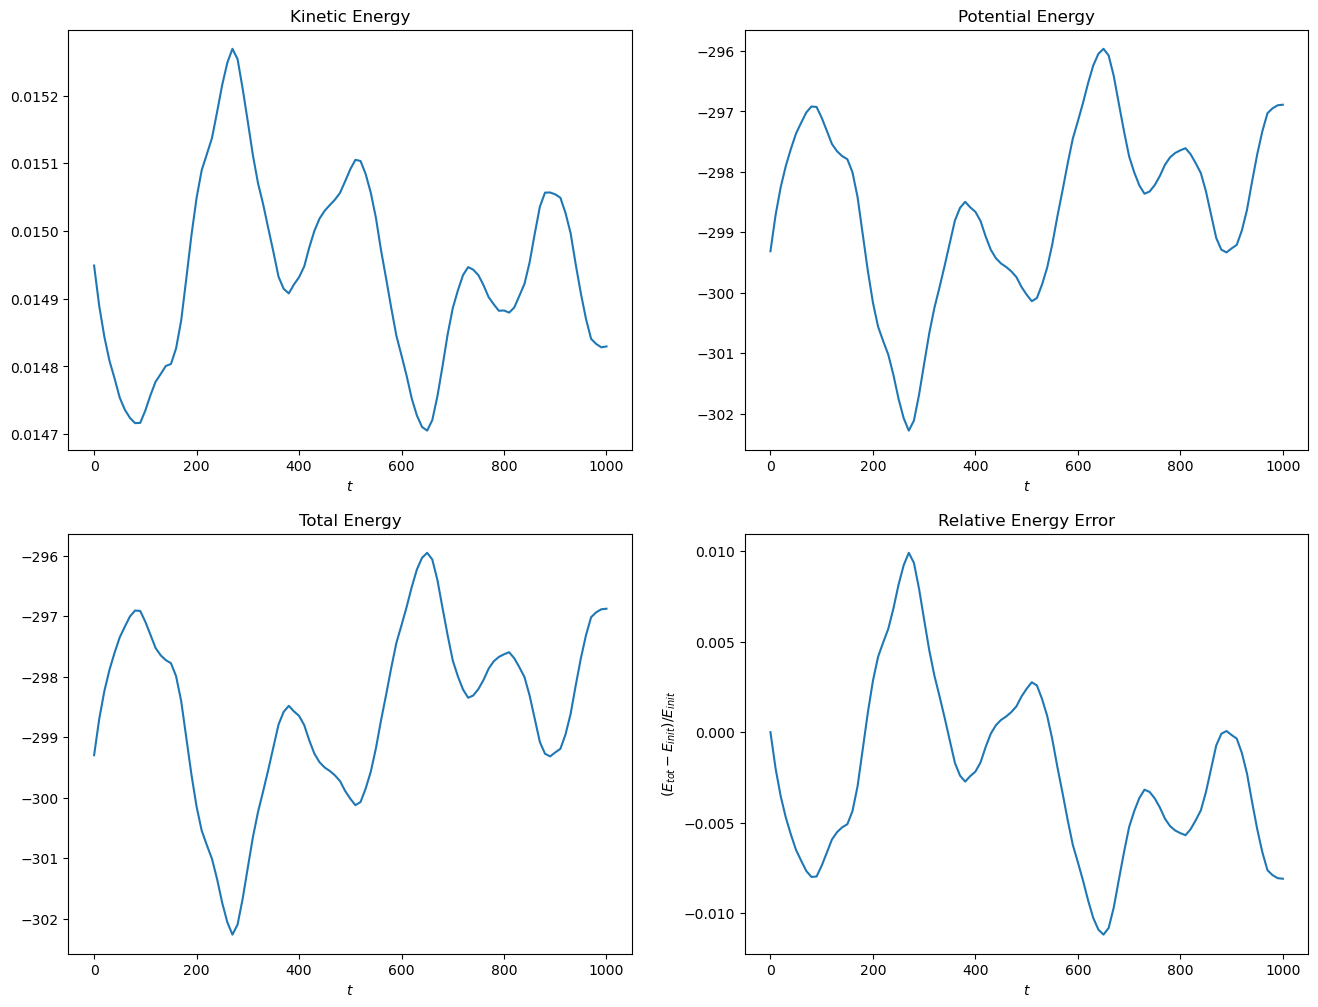

In [187]:
# ENERGY PLOTS

#----------------------------------------------------------------------
# These are ordered to match the Energy_keys
title_labels = ["Kinetic Energy", "Potential Energy", "Total Energy"]

n_rows = 2
n_col = 2

fig, ax = plt.subplots(n_rows, n_col, figsize=(16,12))

index = 0 # Index to count cycles and break
for i in range(n_rows):
    for j in range(n_col):
        ax[i][j].set_title(title_labels[index])
        ax[i][j].plot(time_stamp, Energy[Energy_keys[index]])
        ax[i][j].set_xlabel("$t$")

        index +=1
        if index == 3:
            break

ax[1][1].set_title("Relative Energy Error")
ax[1][1].plot(time_stamp, Energy_rel_e)
ax[1][1].set_xlabel("$t$")
ax[1][1].set_ylabel("$(E_{tot}-E_{init})/E_{init}$")
# ax[1][1].set_xlim(0, 1000)

collapse_index = np.argmax(Energy['kin'])
print("'kin' Collpase time = " + str(time_stamp[collapse_index]))

collapse_index = np.argmin(Energy['pot'])
print("'pot' Collpase time = " + str(time_stamp[collapse_index]))

figures.append(fig)
figures_names.append("energy")

plt.show()

In [188]:
# TOTAL ENERGY OF EACH PARTICLE

#----------------------------------------------------
# Initialize an array for the total energy of every particle at every time
# It works like this: particle_E_tot[time_index][particle_index]
particle_E_tot = np.zeros((len(snapshots), N))

for time_index in range(len(snapshots)): # Pick a certain time
    for i in range(N): # Pick a certain particle
        # Add its kinetic energy
        particle_E_tot[time_index][i] += particles_E_kin[time_index][i]
        # Add all its gravitational interactions with all other particles
        # particles_E_pot[time_index][i] allready contains the overall potential of particle i
        particle_E_tot[time_index][i] += particles_E_pot[time_index][i]
        
# Create a mask that tells if, at any time, any particle is bounded
is_particle_bounded = particle_E_tot < 0

# Count how many particles are bounded at any time
negative_E_tot_particles = np.sum(is_particle_bounded, axis=1)

In [189]:
# PARTICLES INSIDE LAGRANGIAN RADII

#------------------------------------------------------
# We want to count how many particles stay inside some lagrangian radii
# particle_distance_cm works like this: particle_distance_cm[particle_index][time_index]
particles_distance_cm = get_3D_vec(snapshots, 'all', 'pos', absval=1, rf='cm')

# Swap the axis in order to have particle_distance_cm[time_index][particle_index]
particles_distance_cm = np.swapaxes(particles_distance_cm, 0, 1)

In [190]:
# Define some lagrangian_radii using quantiles to be applied to the radii distribution
# We can do this because our particles have the same mass
lagrangian_radii_frac = [0.2, 0.4, 0.6, 0.8]

# Compute the lagrangian radii at every time
# lagrangian_radii[r_index][time_index]
lagrangian_radii = np.quantile(particles_distance_cm, lagrangian_radii_frac, axis=1)

# Compute the time average of the lagrangian radii at every time
# mean_lagrangian_radii[r_index]
mean_lagrangian_radii = np.mean(lagrangian_radii, axis=1)

# Compute the expected lagrangian radii
expected_lagrangian_radii = [expected_lagrangian_radius(b=10, q=lagrangian_radii_frac[i]) for i in range(len(lagrangian_radii_frac))]

# Make colors of the lagrangian_radii. Use indexes to access them
# lr_colors[r_index]
lr_colors = plt.colormaps.get_cmap('gist_rainbow')(np.linspace(0, 1, len(lagrangian_radii_frac)))
# lr_colors = plt.cm.rainbow(np.linspace(0, 1, len(lagrangian_radii_frac)))

# Make labels for the lagrangian radii
lr_labels = [r'$R_{{L}}(q={0})$'.format(lagrangian_radii_frac[i]) for i in range(len(lagrangian_radii_frac))]

In [191]:
# Create a mask that tells if, at any time, any particle is inside any lagrangian radius
# is_particle_inside_lagra_radii[r_index][time_index][particle_index]
is_particle_inside_lagra_radii = np.array([particles_distance_cm <= mean_lagrangian_radii[i] for i in range(len(mean_lagrangian_radii))])

# Count how many particles are inside the lagrangian radii at any time
# particles_inside_lagra_radii[r_index][time_index]
particles_inside_lagra_radii = np.array([np.sum(is_particle_inside_lagra_radii[i], axis=1) for i in range(len(mean_lagrangian_radii))])

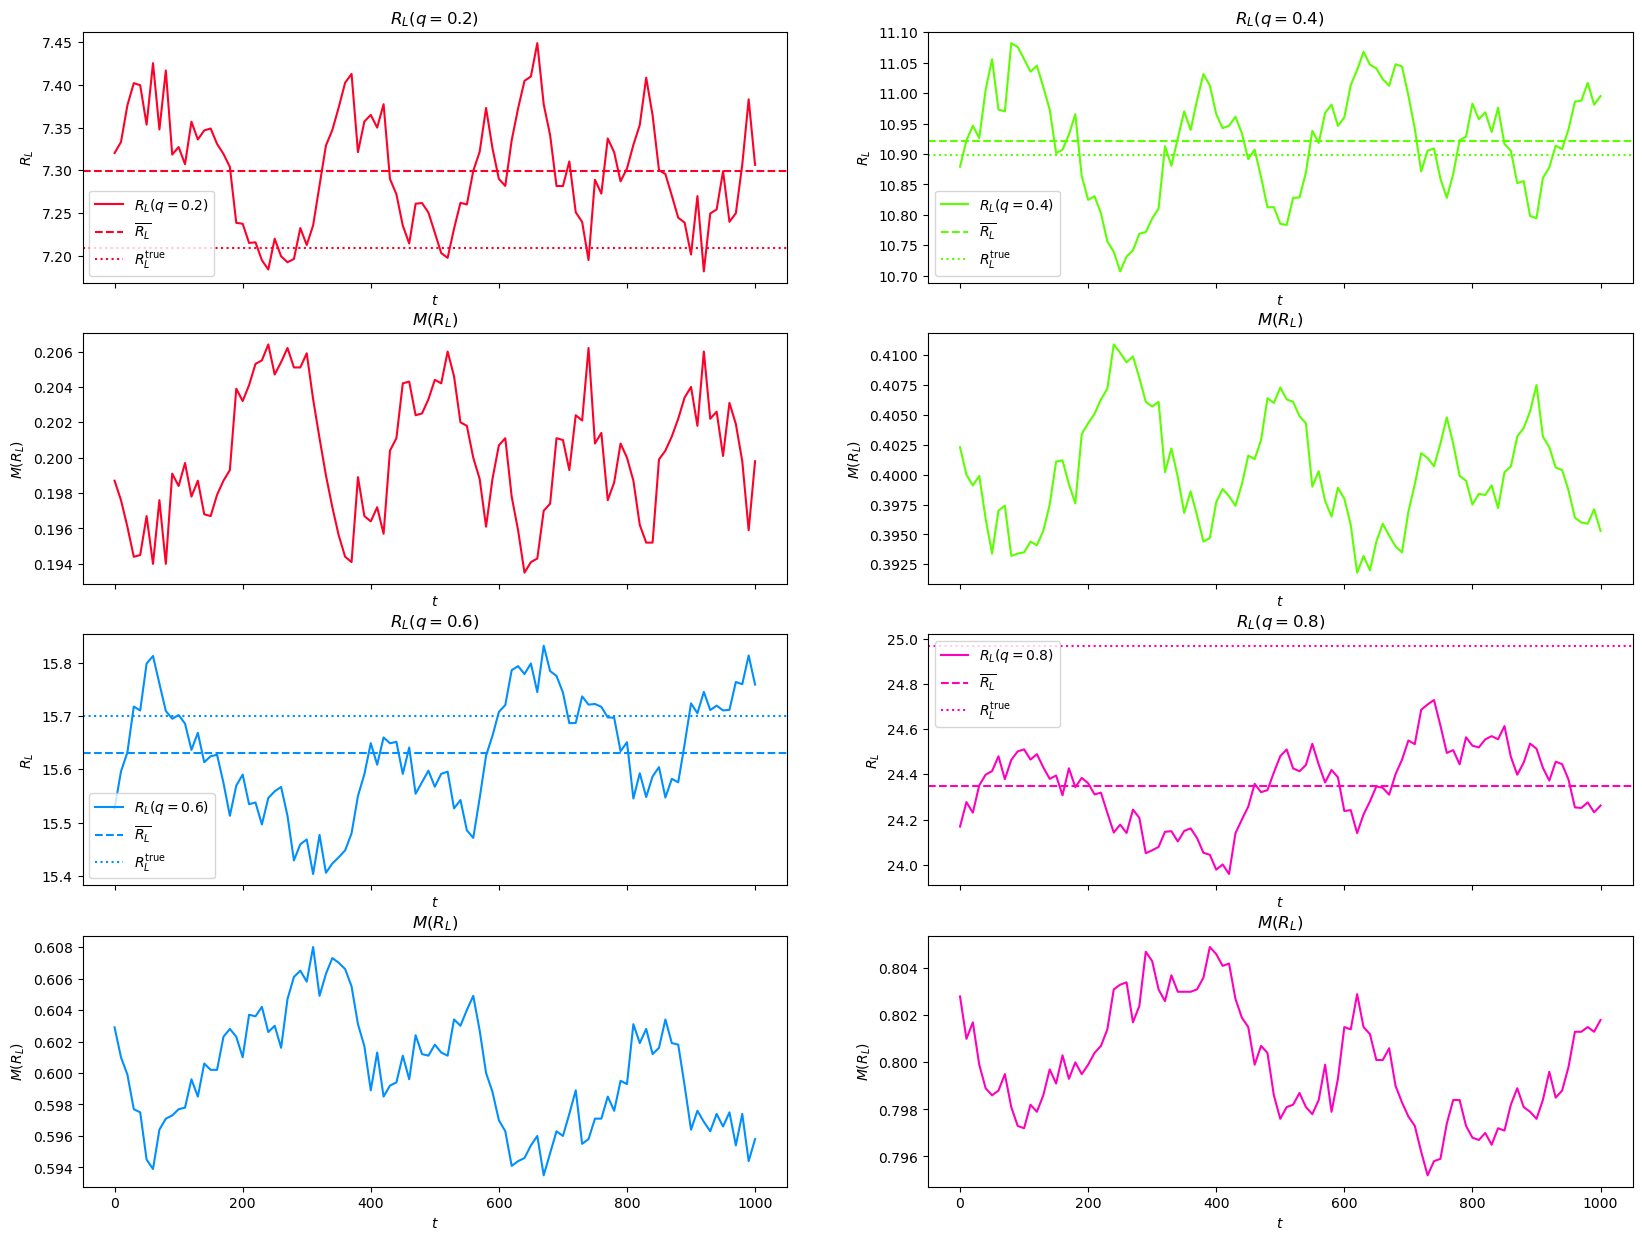

In [192]:
n_rows = 4
n_cols = 2

radii_rows = [0, 2]
masses_rows = [1, 3]

plt_index = 0

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15), sharex=True)

for row in radii_rows:
    for ax in axes[row, :]:
        ax.set_title(lr_labels[plt_index])
        ax.set_xlabel(r'$t$')
        ax.set_ylabel(r'$R_L$')

        ax.plot(time_stamp, lagrangian_radii[plt_index], label=lr_labels[plt_index], color=lr_colors[plt_index])
        ax.axhline(mean_lagrangian_radii[plt_index], linestyle='--', color=lr_colors[plt_index], label=r'$\overline{R_L}$')
        ax.axhline(expected_lagrangian_radii[plt_index], linestyle=':', color=lr_colors[plt_index], label=r'$R_L^{\text{true}}$')

        plt_index += 1

        ax.legend()

plt_index = 0
for row in masses_rows:
    for ax in axes[row, :]:
        ax.set_title(r'$M(R_L)$')
        ax.set_xlabel(r'$t$')
        ax.set_ylabel(r'$M(R_L)$')

        ax.plot(time_stamp, particles_inside_lagra_radii[plt_index] * snapshots[0][2][0][0], label=lr_labels[plt_index], color=lr_colors[plt_index])

        plt_index += 1

plt.show()

In [194]:
# CENTER OF MASS OF THE NEW BOUND SYSTEM

#-------------------------------------------------------------
# We want to find the center of mass of the new bound system using get_center_of_mass()
# Do that by passing to the function, at a given time, the indexes of the particles to
# be considered in the computation

# Select, at every time, the indexes of the bounded particles
# bounded_indexes is a list of numpy arrays
# selecting index 0 of np.where() output is just because of how it works
bounded_indexes = [np.where(is_particle_bounded[time_index] == True)[0]
                   for time_index in range(len(snapshots))]

In [195]:
# Compute the new center of mass at every time
new_cm_pos = np.array([get_center_of_mass(snapshots, time_index, vec='pos',
                                          particle_indexes=bounded_indexes[time_index])
                                          for time_index in range(len(snapshots))])

In [196]:
# IMAGE SAVER

#------------------------------------------------------------

# Toggle on/off the image saver
save_images = False

if save_images:
    # FOLDERS MANAGING

    #-------------------------------------------------------------------------
    # File paths variables
    images_dir_path = "images"

    # Create folders to store the images
    if not os.path.isdir(images_dir_path):
        os.makedirs(images_dir_path)
    
    # Empty the 'images' folder
    for file_name in os.listdir(images_dir_path):
        file_path = os.path.join(images_dir_path, file_name)
        os.remove(file_path)

    #---------------------------------------------------------------------
    # SAVING IMAGES
    for figure_index in range(len(figures)):
        figures[figure_index].savefig(os.path.join(images_dir_path, figures_names[figure_index]))

In [197]:
# MOVIE MAKER

#------------------------------------------------------------------------

# Toggle on/off the movie maker
make_movie = False

if make_movie:
    # FOLDERS MANAGING

    #-------------------------------------------------------------------------
    # File paths variables
    movie_dir_path = "movie"
    frames_dir_path = os.path.join(movie_dir_path, "frames")
    movie_frame_name_prefix = "snapshot_img_"
    movie_name = "movie.mp4"

    # Create folders to store the movie and its frames
    if not os.path.isdir(movie_dir_path):
        os.makedirs(frames_dir_path)
    
    # Empty the 'frames' folder
    for file_name in os.listdir(frames_dir_path):
        file_path = os.path.join(frames_dir_path, file_name)
        os.remove(file_path)
    
    # Empty the 'movie' folder
    for file_name in os.listdir(movie_dir_path):
        file_path = os.path.join(movie_dir_path, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
    
    #------------------------------------------------------------------------
    # GENERATING FRAMES

    #------------------------------------------------------------------------
    # Rough estimate of the number of frames of the movie
    # Lowering it increases the step between snapshots that are considered
    # Use in a cycle below. If N_frames = len(snapshots) all frames are used
    N_frames = len(snapshots)
    
    # If True, frames will be deleted after the movie has been assembled
    delete_frames = True

    # In order to efficiently plot data with the purpose of making a movie is useful
    # to swap the axis of the array. This is not necessary, but otherwise plotting fucntions
    # would take a lot of time to run
    # "new_pos" works like this: new_pos[time_index][coordinate_index][particle_index]
    # So new_pos[time_index][coordinate_index] gives the values of the specified
    # coordinate at the specified time for all particles
    image_pos = np.swapaxes(pos, 0, 1) # Swap particle and time
    image_pos = np.swapaxes(image_pos, 1, 2) # Swap particle and coordinate

    # Initialize a list to store the colors of each particle at any time
    particles_colors = []

    color_cm = 'black'

    #-------------------------------------------------------------------------
    # Get minimum and maximum energy to normalize the colormap
    E_k_min = np.min(particles_E_kin)
    E_k_max = np.max(particles_E_kin)

    # For every snapshot (or for some of them depending of the step of the range() call)
    # plot the positon of every particle in 3D space
    for time_index in tqdm(range(0, len(snapshots), int(len(snapshots) / N_frames))):
        # Initialize a 3D plot
        fig = plt.figure(figsize=(16, 9))

        # computed_zorder=False is to allow manual setting of the order of the plots
        ax = fig.add_subplot(projection='3d', computed_zorder=False)
        ax.set_box_aspect(None, zoom=0.9) # To prevent z axis label to be cut off

        # Plot the points and save the returned value from scatter() to make a colorbar
        p_plot = ax.scatter(image_pos[time_index][0], image_pos[time_index][1], image_pos[time_index][2],
                            zorder=0, c=particles_E_kin[time_index], alpha=0.8,
                            norm=colors.LogNorm(E_k_min, E_k_max), cmap=plt.colormaps.get_cmap('jet'))
        ax.scatter(cm_pos[time_index][0], cm_pos[time_index][1], cm_pos[time_index][2],
                   color=color_cm, zorder=1)
        
        # Plot the colorbar
        cb = fig.colorbar(p_plot, ax=ax, location='right', shrink=0.75)
        cb.set_label(r"$E_{kin}$", fontsize=15)
        
        # For the first snapshot register the axes limit
        if time_index == 0:
            x_lim = ax.get_xlim()
            y_lim = ax.get_ylim()
            z_lim = ax.get_zlim()
        
        # Set e cubic plot for every snapshot and fix the axes limit to the initial ones
        ax.set_aspect('equal', 'datalim')
        ax.set_xlim(x_lim)
        ax.set_ylim(y_lim)
        ax.set_zlim(z_lim)

        # Set the snapshot time stamp as the title of every plot
        t = float(np.format_float_scientific(time_stamp[time_index], 2))
        ax.set_title(r"$t={t}$".format(t=t))
        ax.set_xlabel(r"$x$")
        ax.set_ylabel(r"$y$")
        ax.set_zlabel(r"$z$")

        # Save the current figure with a proper name
        # zfill() is needed to achieve alphanumerical order later
        frame_name = movie_frame_name_prefix + str(time_index).zfill(5) + ".png"
        frame_path = os.path.join(frames_dir_path, frame_name)
        fig.savefig(frame_path)

        # Close the current plot
        plt.close()

    #--------------------------------------------------------------------
    # ASSEMBLING FRAMES

    #--------------------------------------------------------------------
    # Get all the files in the frames directory and sort them in alphanumerical order
    movie_img_files = os.listdir(frames_dir_path)
    movie_img_files = sorted(movie_img_files)

    movie_path = os.path.join(movie_dir_path, movie_name)

    # Use the imageio writer to build the movie by appending to it every frame
    # Default fps is 10. 'I' stands for 'multiple images'
    with imageio.get_writer(movie_path, mode='I', fps=10) as writer:
        for filename in movie_img_files:
            image = imageio.imread(os.path.join(frames_dir_path, filename)) # Get the frame
            writer.append_data(image) # Append the frame
    
    # Delete individual frames if requested
    if delete_frames:
        for file_name in os.listdir(frames_dir_path):
            file_path = os.path.join(frames_dir_path, file_name)
            os.remove(file_path)